# IMPORT LIBS

In [3]:
import numpy as np
import pandas as pd
import missingno as msno


import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [4]:
#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
from wordcloud import WordCloud, STOPWORDS

# UNDERSTAND DATA

In [6]:
df = pd.read_csv("./database_netflix.csv")

In [7]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,25-Sep-21,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,24-Sep-21,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,24-Sep-21,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,24-Sep-21,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,24-Sep-21,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


DATA OVERVIEW

In [8]:
df.shape

(8807, 12)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8800 non-null   object
 9   duration      8807 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [10]:
df['date_added'].dropna(inplace=True)

In [11]:
country_null_values = df.country.isnull().sum()

df['country'].fillna('United States', inplace=True)
df['country_single'] = df['country'].apply(lambda x: x.split(",")[0])

In [12]:
df['rating'].unique()

array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', nan, 'NR', 'TV-Y7-FV', 'UR'], dtype=object)

In [13]:
ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Older Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Older Kids',
    'PG': 'Older Kids',
    'G': 'Older Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}
df['target_ages'] = df['rating'].replace(ratings_ages)
df['target_ages'].unique()

array(['Teens', 'Adults', 'Older Kids', nan], dtype=object)

In [14]:
df.duplicated().sum()

0

In [15]:
#Transform into year_added, month_added, quarter_added, day_of_week from date_added
df["date_added"] = pd.to_datetime(df['date_added'])
df['day_added'] = df['date_added'].dt.day.astype("Int64")
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

C:\Users\trime\AppData\Local\Temp\ipykernel_10724\1547914708.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date_added"] = pd.to_datetime(df['date_added'])


In [16]:
df['date_of_week'] = df['date_added'].dt.day_name()
df['date_of_week']

0        Saturday
1          Friday
2          Friday
3          Friday
4          Friday
          ...    
8802    Wednesday
8803       Monday
8804       Friday
8805     Saturday
8806     Saturday
Name: date_of_week, Length: 8807, dtype: object

In [17]:
#single_genre vs multiple genre
df['genre'] = df['listed_in'].apply(lambda x: x.split(",")[0])

Concise Summary

In [18]:
for c in ['type','date_added','release_year','duration']:
    print('*',)
    print(df[c].describe())

*
count      8807
unique        2
top       Movie
freq       6131
Name: type, dtype: object
*
count                             8797
mean     2019-05-17 05:59:08.436967168
min                2008-01-01 00:00:00
25%                2018-04-06 00:00:00
50%                2019-07-02 00:00:00
75%                2020-08-19 00:00:00
max                2021-09-25 00:00:00
Name: date_added, dtype: object
*
count    8807.000000
mean     2014.180198
std         8.819312
min      1925.000000
25%      2013.000000
50%      2017.000000
75%      2019.000000
max      2021.000000
Name: release_year, dtype: float64
*
count         8807
unique         220
top       1 Season
freq          1793
Name: duration, dtype: object


# PERFORMING EDA

## Distribution types


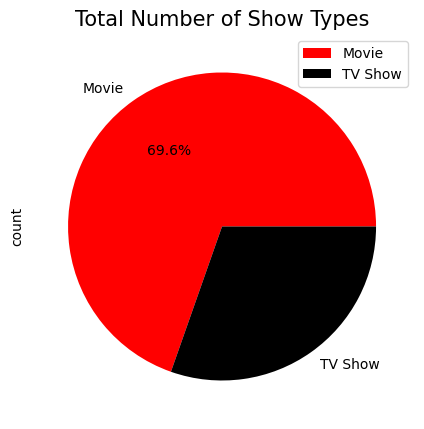

In [19]:
# Assuming 'df' is your DataFrame and 'type' is a column in it
# Count the number of occurrences of each show type
shows = df['type'].value_counts()

# Specify colors for the pie chart slices
colors = ['red', 'black']

# Create a pie chart of the show types
shows.plot.pie(figsize=(5, 5), autopct='%1.1f%%', fontsize=10, colors=colors)

# Add a title and legend to the chart
plt.title('Total Number of Show Types', fontsize=15, fontfamily='sans-serif')
plt.legend(loc='upper right')

# Display the plot
plt.show()


## Movies & TV Shows added over time

In [20]:
#new df content by type
df_movies = df.loc[df["type"]=="Movie"]
df_tv_shows = df.loc[df["type"]=="TV Show"]

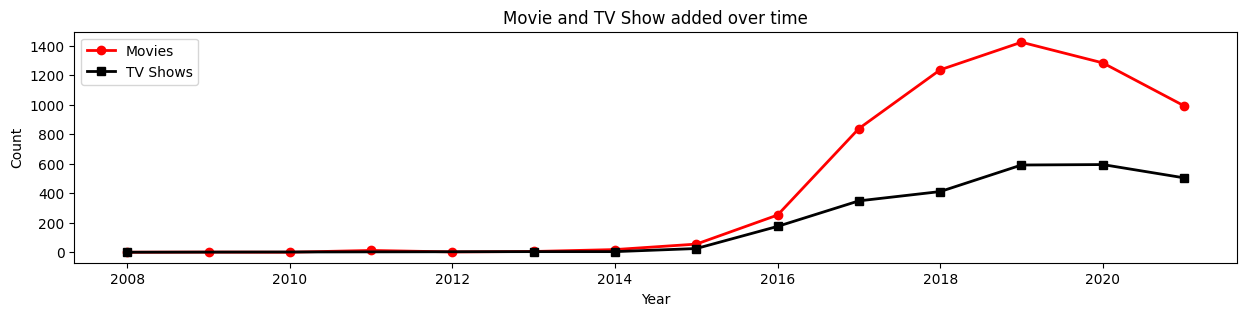

In [21]:
movies_count = df_movies['year_added'].value_counts().sort_index()
tv_shows_count = df_tv_shows['year_added'].value_counts().sort_index()

# Create a line chart to visualize the trends over time
plt.figure(figsize=(15, 3))
plt.plot(movies_count.index, movies_count.values, color='red',
label='Movies',linewidth=2, marker='o')
plt.plot(tv_shows_count.index, tv_shows_count.values, color='k',
label='TV Shows', linewidth=2, marker='s')



# Customize the plot
plt.title('Movie and TV Show added over time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()


# Show the plot
plt.show()

###  # delta: year_added vs. release_year --> Is Netflix add new films only? (hue='type_of_content')

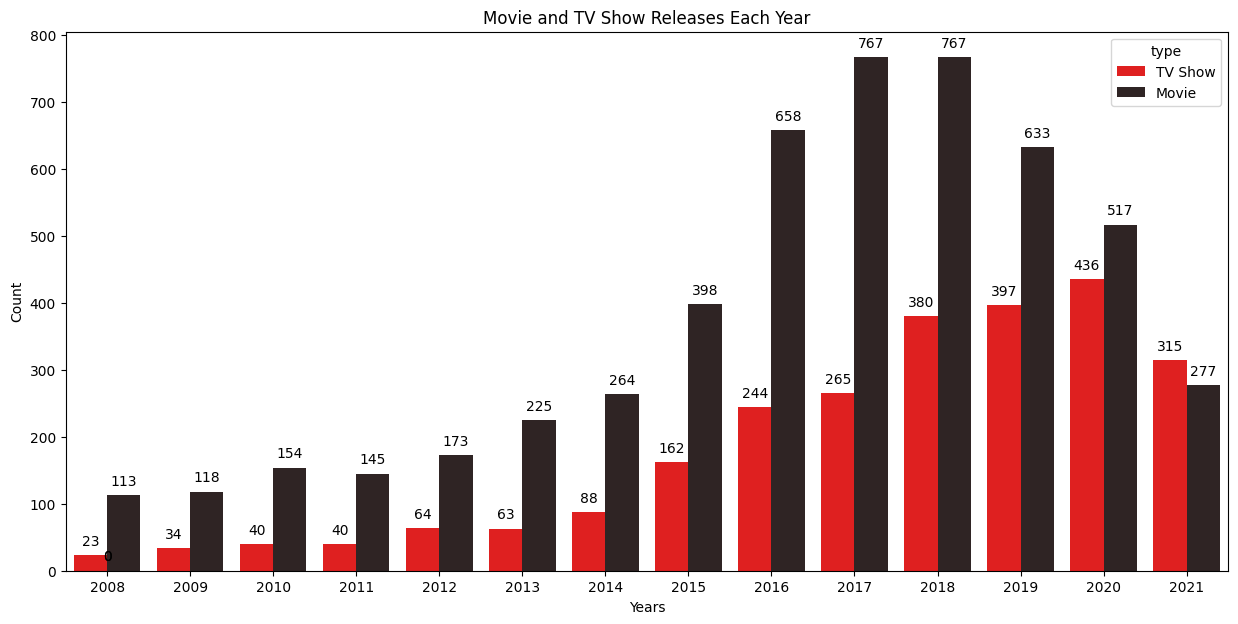

In [22]:
order = range(2008, 2022)

plt.figure(figsize=(15, 7))

ax = sns.countplot(x='release_year', data=df, hue='type', order=order, palette="dark:red_r")

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Movie and TV Show Releases Each Year')
plt.xlabel('Years')
plt.ylabel('Count')

plt.show()


## Content structure by Ratings

In [23]:
release_recent_year = df_movies[df_movies['release_year'].between(2008, 2021)]
release_recent_year.head(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,country_single,target_ages,day_added,year_added,month_added,date_of_week,genre
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",United States,Teens,25,2021.0,9.0,Saturday,Documentaries
6,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",United States,2021-09-24,2021,PG,91 min,Children & Family Movies,Equestria's divided. But a bright-eyed hero be...,United States,Older Kids,24,2021.0,9.0,Friday,Children & Family Movies
9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,2021-09-24,2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...,United States,Teens,24,2021.0,9.0,Friday,Comedies
12,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic",2021-09-23,2021,TV-MA,127 min,"Dramas, International Movies",After most of her family is murdered in a terr...,Germany,Adults,23,2021.0,9.0,Thursday,Dramas
13,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,"Klara Castanho, Lucca Picon, Júlia Gomes, Marc...",United States,2021-09-22,2021,TV-PG,91 min,"Children & Family Movies, Comedies",When the clever but socially-awkward Tetê join...,United States,Older Kids,22,2021.0,9.0,Wednesday,Children & Family Movies
16,s17,Movie,Europe's Most Dangerous Man: Otto Skorzeny in ...,"Pedro de Echave García, Pablo Azorín Williams",NaN,United States,2021-09-22,2020,TV-MA,67 min,"Documentaries, International Movies",Declassified documents reveal the post-WWII li...,United States,Adults,22,2021.0,9.0,Wednesday,Documentaries
18,s19,Movie,Intrusion,Adam Salky,"Freida Pinto, Logan Marshall-Green, Robert Joh...",United States,2021-09-22,2021,TV-14,94 min,Thrillers,After a deadly home invasion at a couple’s new...,United States,Teens,22,2021.0,9.0,Wednesday,Thrillers
23,s24,Movie,Go! Go! Cory Carson: Chrissy Takes the Wheel,"Alex Woo, Stanley Moore","Maisie Benson, Paul Killam, Kerry Gudjohnsen, ...",United States,2021-09-21,2021,TV-Y,61 min,Children & Family Movies,From arcade games to sled days and hiccup cure...,United States,Older Kids,21,2021.0,9.0,Tuesday,Children & Family Movies
27,s28,Movie,Grown Ups,Dennis Dugan,"Adam Sandler, Kevin James, Chris Rock, David S...",United States,2021-09-20,2010,PG-13,103 min,Comedies,Mourning the loss of their beloved junior high...,United States,Teens,20,2021.0,9.0,Monday,Comedies
28,s29,Movie,Dark Skies,Scott Stewart,"Keri Russell, Josh Hamilton, J.K. Simmons, Dak...",United States,2021-09-19,2013,PG-13,97 min,"Horror Movies, Sci-Fi & Fantasy",A family’s idyllic suburban life shatters when...,United States,Teens,19,2021.0,9.0,Sunday,Horror Movies


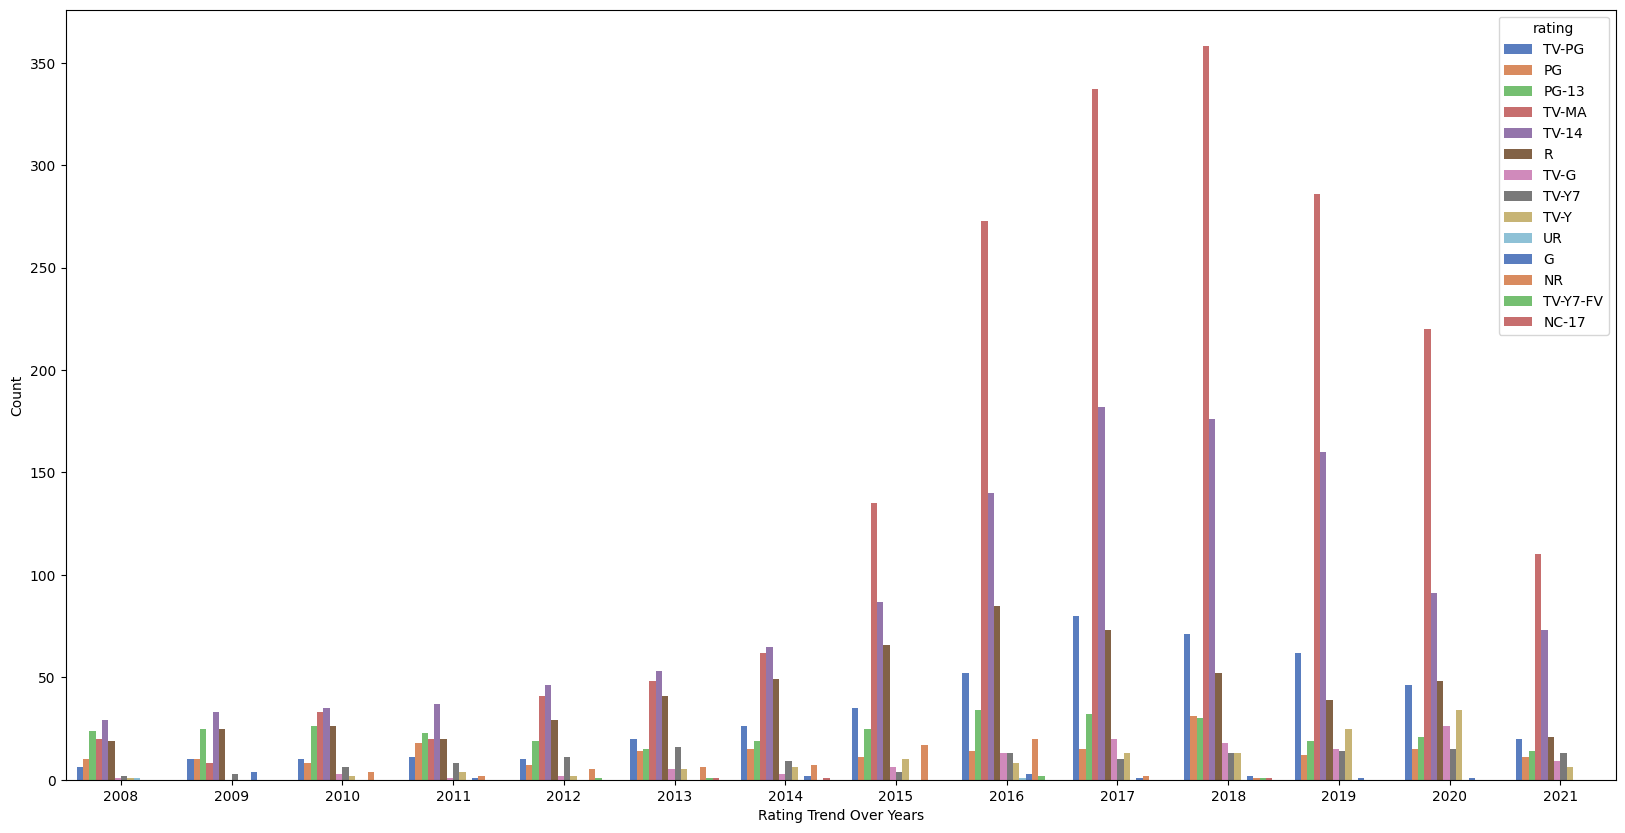

In [26]:
plt.figure(figsize=(20, 10))
sns.countplot(data=release_recent_year, x='release_year', hue='rating',palette='muted')

#setting chart
plt.xlabel('Rating Trend Over Years')
plt.ylabel('Count')


plt.show()


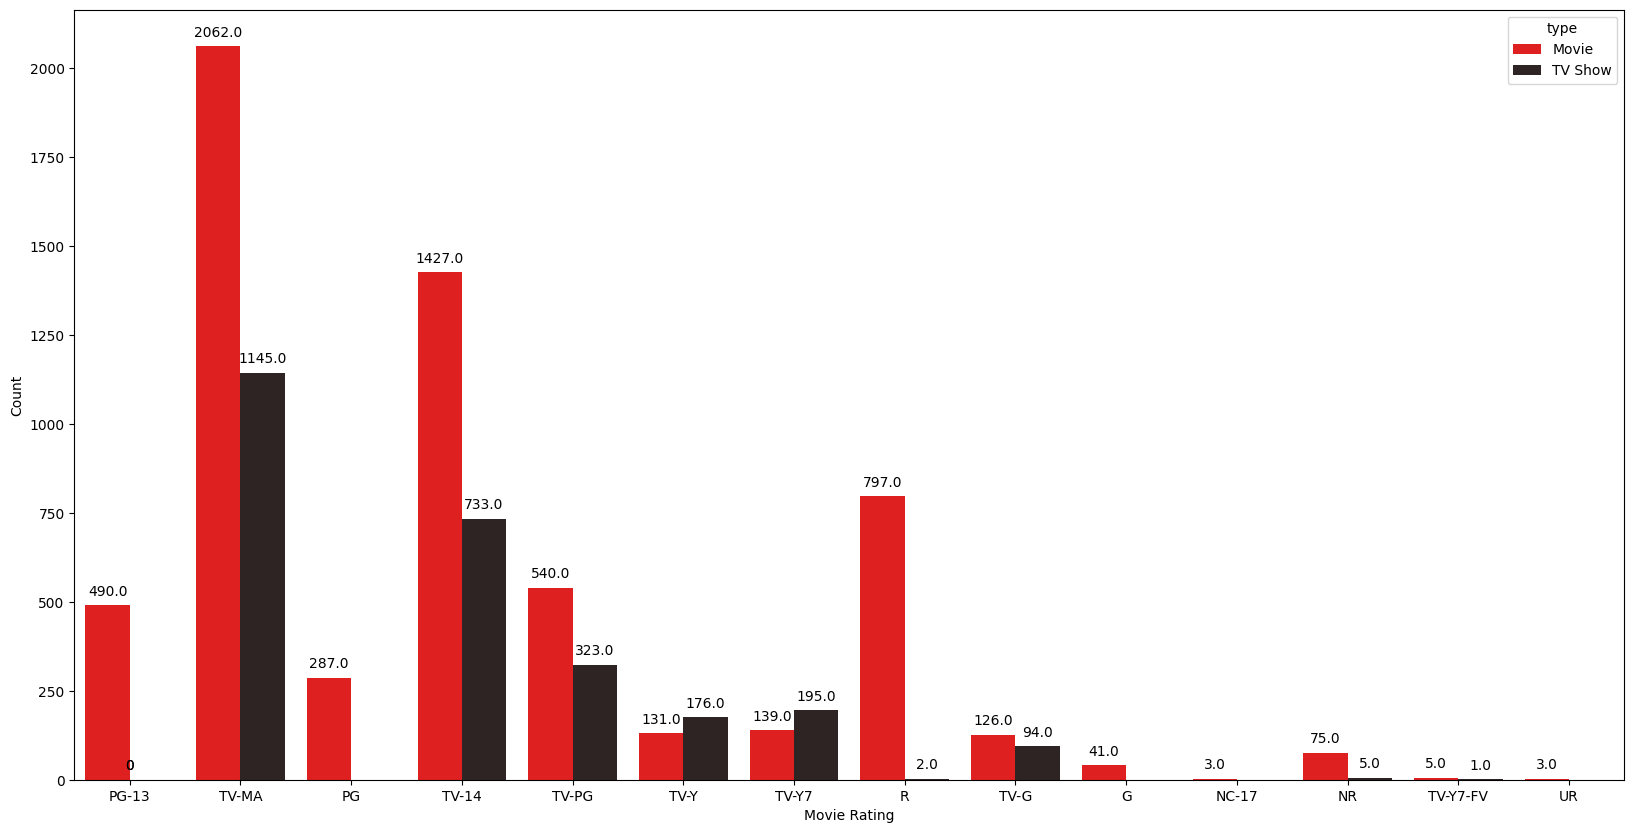

In [27]:
# Assuming df is your DataFrame and 'rating' is a categorical column
rating_counts = df['rating'].value_counts()

plt.figure(figsize=(20, 10))
ax = sns.countplot(data=df, x='rating', palette="dark:red_r", hue='type')

plt.xlabel('Movie Rating')
plt.ylabel('Count')

# Add count numbers above the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


## Content structure by time
- Month
- Day of Month
- Day Of Week

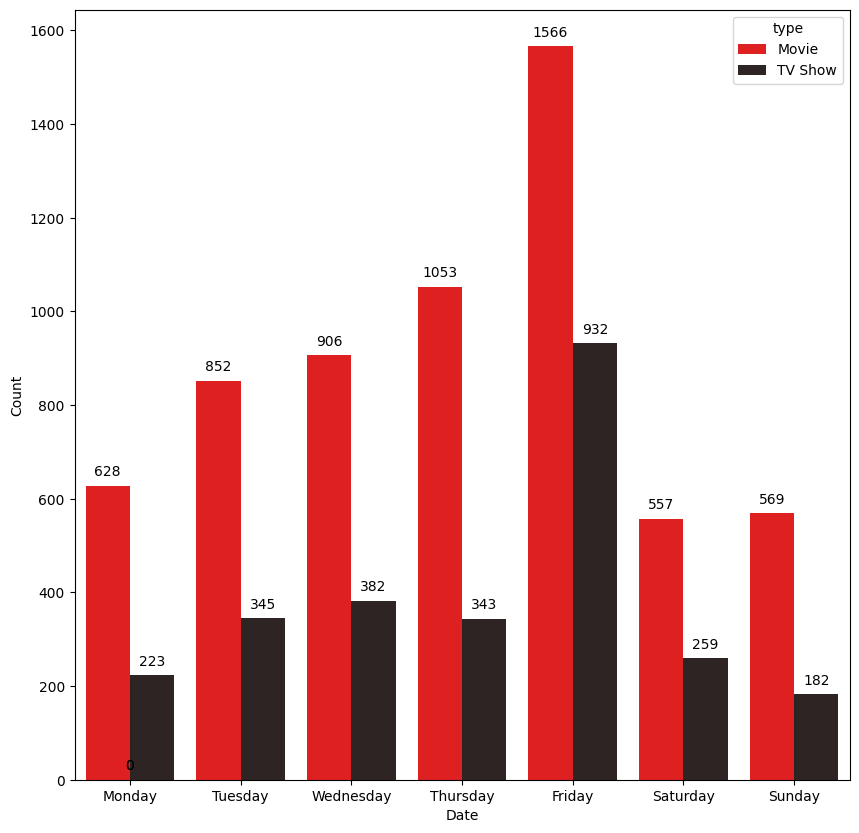

In [28]:
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

daily_counts = df.groupby(['date_of_week', 'type']).size().reset_index().rename(columns={0: 'num'}) # order X
df['date_of_week'].value_counts().loc[day_order]

# Determine the maximum count
max_day_count = daily_counts.max()


plt.figure(figsize=(10, 10))
ax = sns.barplot(data=daily_counts, x='date_of_week', y='num', palette="dark:red_r",order = day_order, hue='type')
#plt.title('Most content added per date')
plt.xlabel('Date')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

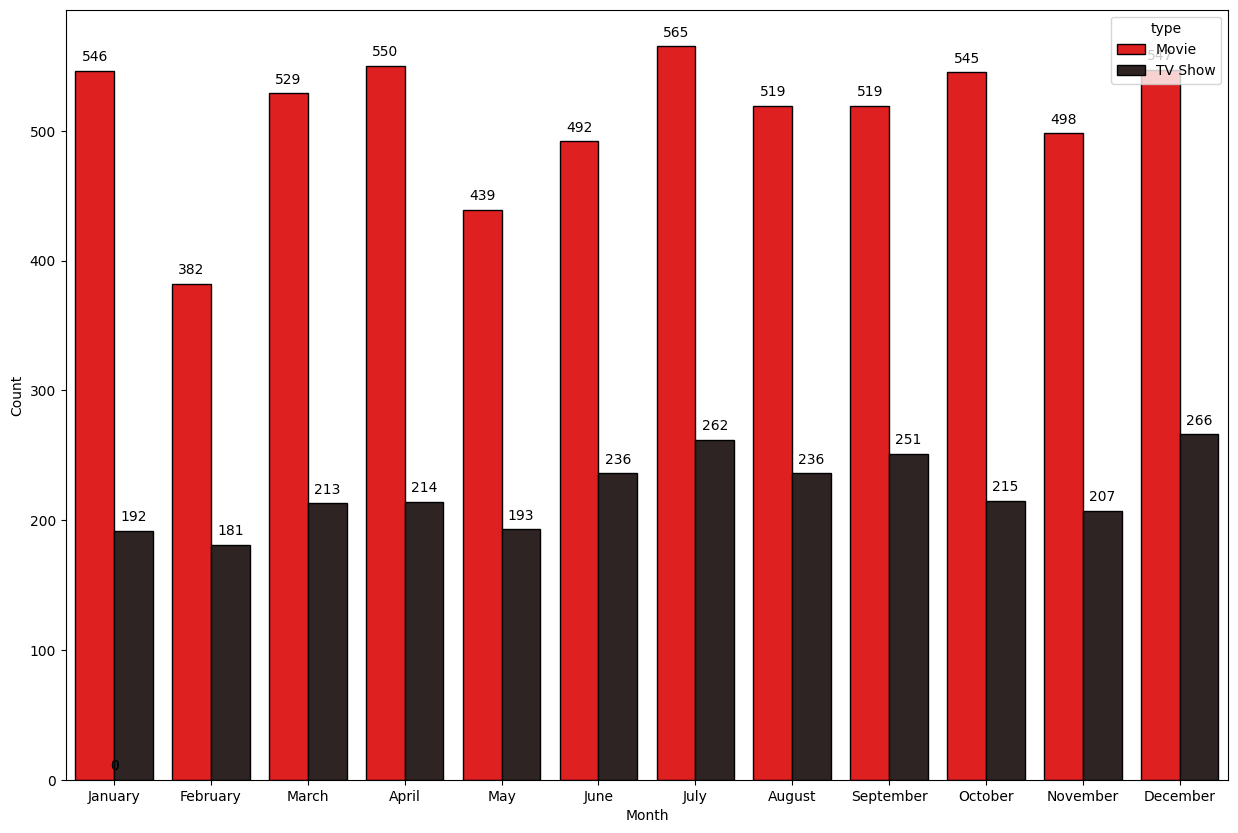

In [29]:
df['month_added'] = pd.to_datetime(df['date_added']).dt.month_name()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July','August', 'September', 'October', 'November', 'December']
monthly_counts = df.groupby(['month_added', 'type']).size().reset_index().rename(columns={0: 'num'})# order X
df['month_added'].value_counts().loc[month_order]
max_month_count = monthly_counts.max()





plt.figure(figsize=(15, 10))
ax = sns.barplot(data = monthly_counts,x='month_added', y='num',palette="dark:red_r", order = month_order,edgecolor='black',hue='type')
#plt.title('Most content added per month')
plt.xlabel('Month')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')


plt.show()

## Content structure by  genres

In [30]:
# Use .loc to explicitly set the values in the original DataFrame
df_movies.loc[:, 'genre'] = df_movies['listed_in'].apply(lambda x: x.split(",")[0])
df_tv_shows.loc[:, 'genre'] = df_tv_shows['listed_in'].apply(lambda x: x.split(",")[0])


C:\Users\trime\AppData\Local\Temp\ipykernel_10724\3898751785.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),ha='center')


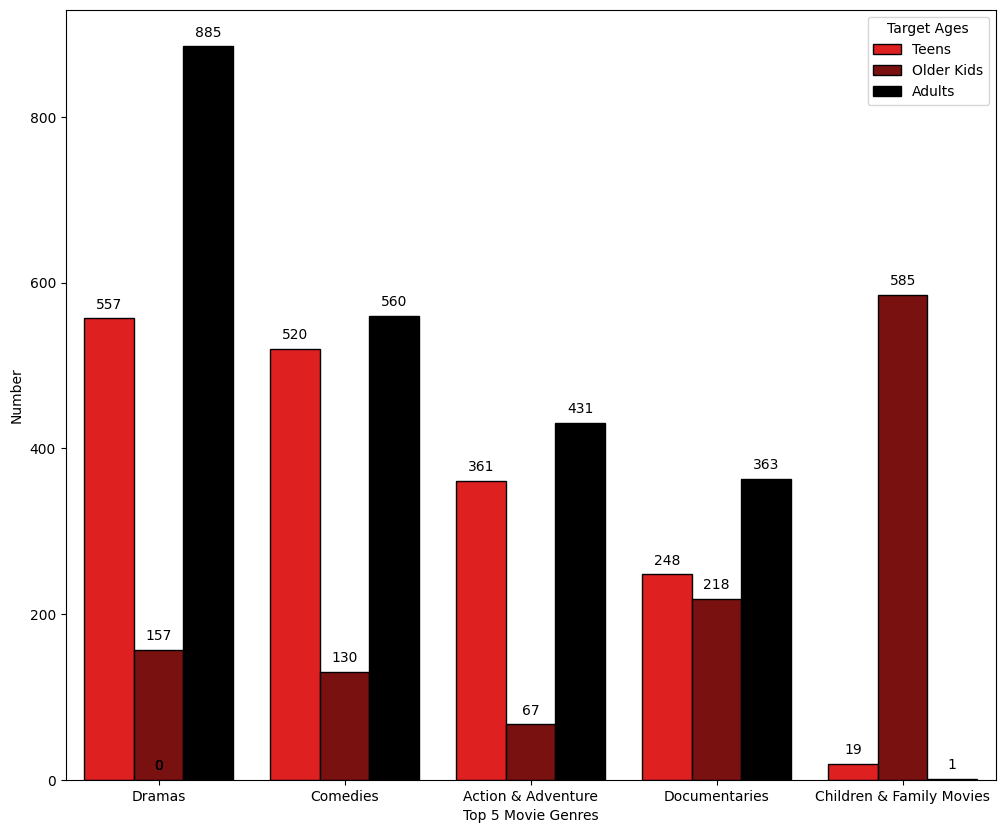

In [31]:
plt.figure(figsize=(12, 10))

# Create the count plot
ax = sns.countplot(x='genre', hue='target_ages', data=df_movies, order=df_movies["genre"].value_counts().index[0:5],
                   palette=['red', 'darkred', 'black'], edgecolor='black')

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(),ha='center')

# Add count numbers above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xlabel('Top 5 Movie Genres')
plt.ylabel('Number')
#plt.title('Distribution of Top 5 Movie Genres by Target Ages')
plt.legend(title='Target Ages')

plt.show()


C:\Users\trime\AppData\Local\Temp\ipykernel_10724\2228317029.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),ha='center')


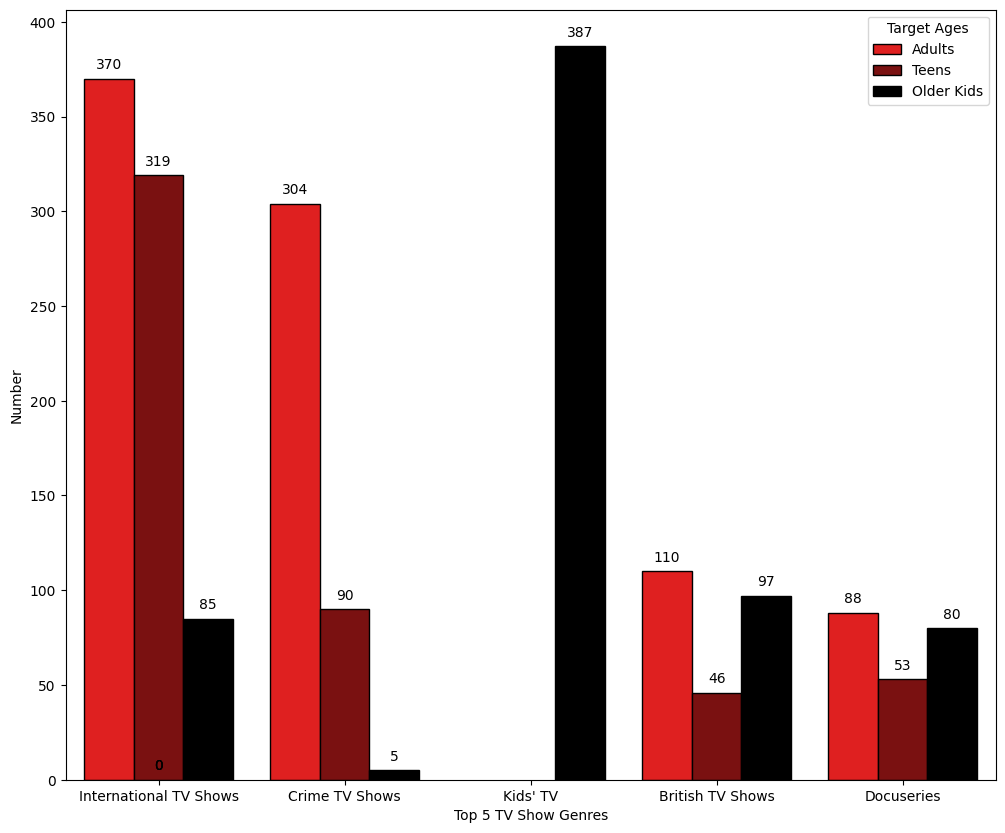

In [32]:
plt.figure(figsize=(12, 10))

# Create the count plot
ax = sns.countplot(x='genre', hue='target_ages', data=df_tv_shows, order=df_tv_shows["genre"].value_counts().index[0:5],
                   palette=['red', 'darkred', 'black'], edgecolor='black')

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(),ha='center')

# Add count numbers above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xlabel('Top 5 TV Show Genres')
plt.ylabel('Number')
#plt.title('Distribution of Top 5 TV Show Genres by Target Ages')
plt.legend(title='Target Ages')

plt.show()


https://help.netflix.com/en/node/2064
- Consider to combine Kids and Older Kids into a single one
- Comment: suggested genres for each customer types
- Most films are movies

## Content structure by durations

In [33]:
temp_duration = df_movies['duration'].apply(lambda x: int(x.split(' ')[0]) if ('min' in str(x)) else x)
temp_duration

0        90
6        91
7       125
9       104
12      127
       ... 
8801     96
8802    158
8804     88
8805     88
8806    111
Name: duration, Length: 6131, dtype: int64

In [34]:
# Split into 30min step, upto 3 hours, 3h+
df_movies.loc[temp_duration.loc[temp_duration < 30].index, 'duration_bin'] = 'Less than 30 min'
df_movies.loc[temp_duration.loc[(temp_duration >= 30)&(temp_duration <60 )].index, 'duration_bin'] = 'More than 30 min - 1 hours'
df_movies.loc[temp_duration.loc[(temp_duration >=60)&(temp_duration<90)].index, 'duration_bin'] = 'More than 1 hours - 1.30 hours'
df_movies.loc[temp_duration.loc[(temp_duration >=90)& (temp_duration < 120)].index,'duration_bin'] = 'More than 1.30 - 2 hours'
df_movies.loc[temp_duration.loc[(temp_duration >=120)&(temp_duration <150)].index, 'duration_bin'] = '2 - 2.30 hours'
df_movies.loc[temp_duration.loc[temp_duration >= 150].index, 'duration_bin'] = 'More than 2.30 hours'

C:\Users\trime\AppData\Local\Temp\ipykernel_10724\2962657034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies.loc[temp_duration.loc[temp_duration < 30].index, 'duration_bin'] = 'Less than 30 min'


In [35]:
duration_movies_counts = df_movies['duration_bin'].value_counts(ascending=False)
max_duration = duration_movies_counts.max()

C:\Users\trime\AppData\Local\Temp\ipykernel_10724\2417922452.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df_movies,x='duration_bin',


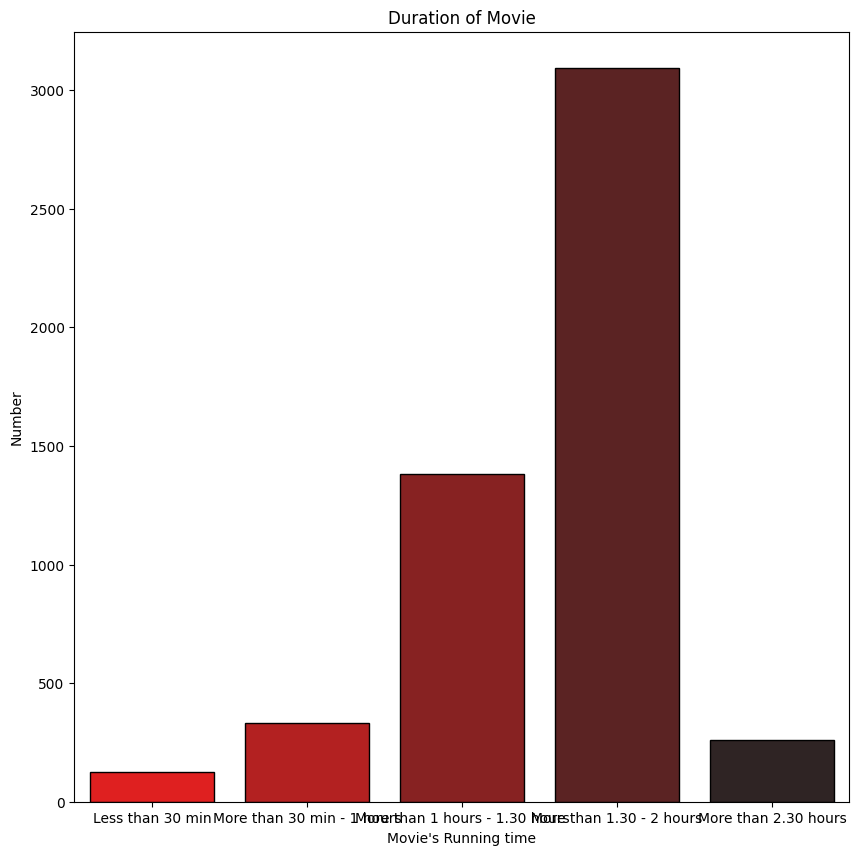

In [36]:
plt.figure(figsize=(10,10))
sns.countplot(data = df_movies,x='duration_bin',
                                          order = ['Less than 30 min','More than 30 min - 1 hours','More than 1 hours - 1.30 hours','More than 1.30 - 2 hours','More than 2.30 hours'],
                                          palette="dark:red_r",edgecolor='black')
plt.xlabel("Movie's Running time")
plt.ylabel("Number")
plt.title('Duration of Movie')

#for index, value in enumerate(duration_movies_counts.values):
#    countplot_movies_duration.text(index, value, str(value), ha='center', va='bottom')
plt.show()

In [37]:
temp_duration_tvshow = df_tv_shows['duration'].apply(lambda x: int(x.split(' ')[0]) if ('Season' in str(x)) else x)


In [38]:

df_tv_shows.loc[temp_duration_tvshow.loc[temp_duration_tvshow == 1].index, 'duration_bin'] = '1 Season'
df_tv_shows.loc[temp_duration_tvshow.loc[temp_duration_tvshow == 2].index, 'duration_bin'] = '2 Seasons'
df_tv_shows.loc[temp_duration_tvshow.loc[temp_duration_tvshow == 3].index, 'duration_bin'] = '3 Seasons'
df_tv_shows.loc[temp_duration_tvshow.loc[temp_duration_tvshow == 4].index, 'duration_bin'] = '4 Seasons'
df_tv_shows.loc[temp_duration_tvshow.loc[temp_duration_tvshow == 5].index, 'duration_bin'] = '5 Seasons'
df_tv_shows.loc[temp_duration_tvshow.loc[temp_duration_tvshow == 6].index, 'duration_bin'] = '6 Seasons'
df_tv_shows.loc[temp_duration_tvshow.loc[temp_duration_tvshow == 7].index, 'duration_bin'] = '7 Seasons'
df_tv_shows.loc[temp_duration_tvshow.loc[temp_duration_tvshow == 8].index, 'duration_bin'] = '8 Seasons'
df_tv_shows.loc[temp_duration_tvshow.loc[temp_duration_tvshow >= 9].index, 'duration_bin'] = '9 Seasons +'

C:\Users\trime\AppData\Local\Temp\ipykernel_10724\4223112484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tv_shows.loc[temp_duration_tvshow.loc[temp_duration_tvshow == 1].index, 'duration_bin'] = '1 Season'


In [39]:
# Suggest preprocessing here to extract number of seasons + combine >9 seasons
duration_tvshows_counts = df_tv_shows['duration_bin'].value_counts()
max_duration_tv = duration_tvshows_counts.max()

C:\Users\trime\AppData\Local\Temp\ipykernel_10724\4003431086.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  countplot_tvshows_duration=sns.countplot(data = df_tv_shows,


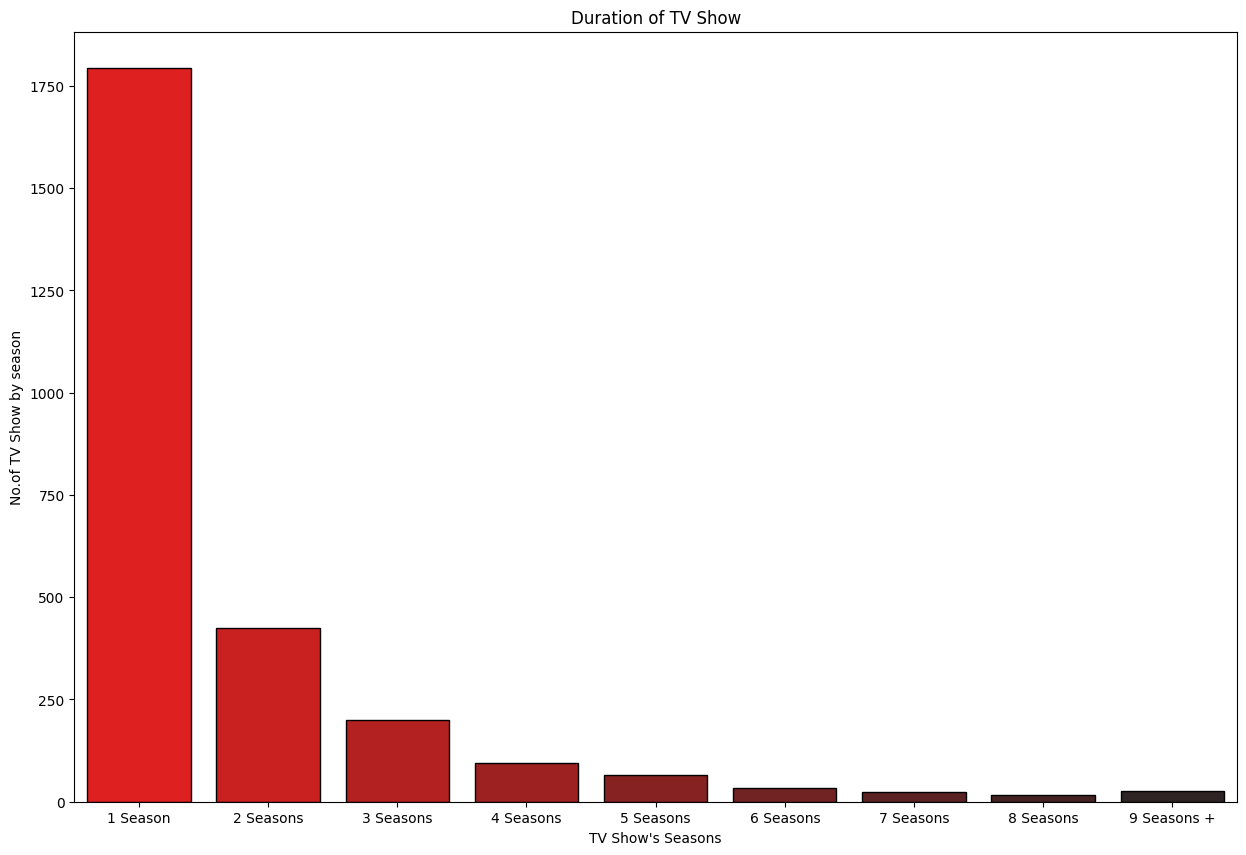

In [40]:
plt.figure(figsize=(15,10))
countplot_tvshows_duration=sns.countplot(data = df_tv_shows,
                                         x='duration_bin',
                                         order = ['1 Season','2 Seasons','3 Seasons','4 Seasons','5 Seasons','6 Seasons','7 Seasons','8 Seasons','9 Seasons +'],
                                         palette="dark:red_r",
                                         edgecolor='black')
plt.title('Duration of TV Show')
plt.xlabel("TV Show's Seasons")
plt.ylabel("No.of TV Show by season")
#plt.xticks(rotation=20)
#for index, value in enumerate(duration_tvshows_counts.values):
#    countplot_tvshows_duration.text(index, value, str(value), ha='center', va='bottom')

plt.show()

## title and description

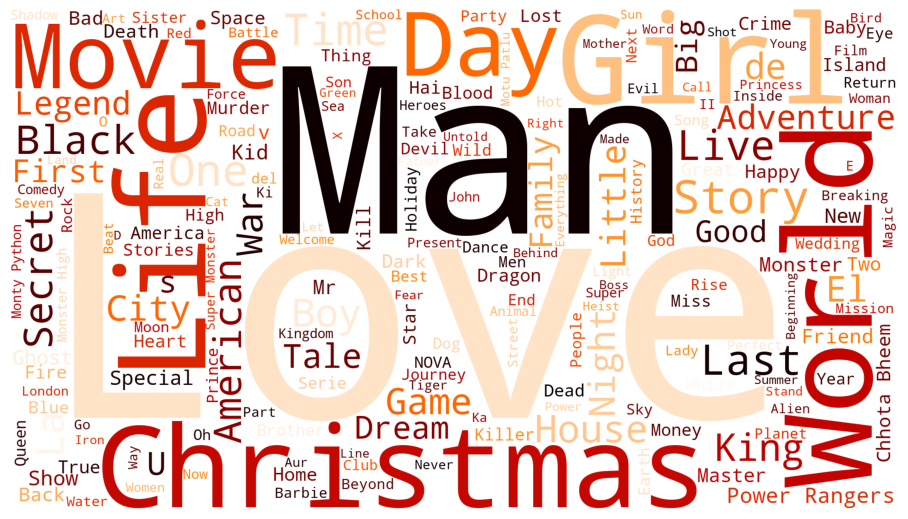

In [41]:
stopwords = set(STOPWORDS)


plt.subplots(figsize=(20,5))
wordcloud = WordCloud(
                          background_color='white',
                          stopwords = stopwords,
                          width=1920,
                          height=1080,
                          colormap = 'gist_heat'
                         ).generate(" ".join(df.title))

plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()



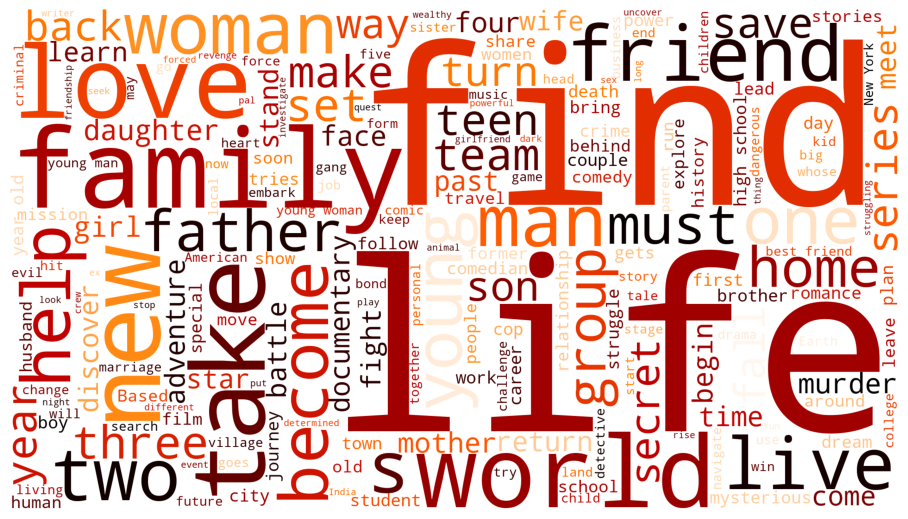

In [42]:
stopwords = set(STOPWORDS)


plt.subplots(figsize=(20,5))
wordcloud = WordCloud(
                          background_color='white',
                          stopwords = stopwords,
                          width=1920,
                          height=1080,
                          colormap = 'gist_heat'
                         ).generate(" ".join(df.description))

plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.tight_layout(pad = 0)

plt.show()

## Content structure by country

In [43]:
from collections import Counter

In [44]:
from plotly.subplots import make_subplots

In [45]:
country_order = df['country_single'].value_counts()[:5].index
countryVScontent = df[['type', 'country_single']].groupby('country_single')['type'].value_counts().unstack().loc[country_order].reset_index()
countryVScontent

type,country_single,Movie,TV Show
0,United States,2804.0,1238.0
1,India,927.0,81.0
2,United Kingdom,382.0,246.0
3,Canada,187.0,84.0
4,Japan,85.0,174.0


In [46]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=countryVScontent['country_single'],
    y=countryVScontent['Movie'],
    name='Movie',

    marker=dict(
        color='rgba(238, 25, 18, 1)'
    )
))

fig.add_trace(go.Bar(
    x=countryVScontent['country_single'],
    y=countryVScontent['TV Show'],
    name='TV Show',

    marker=dict(
        color='rgba(40, 34, 34, 1)'
    )
))


fig.update_layout(
    title={
        'text': 'Top 5 countries provide content on Netflix',
        'y': 0.9,
        'x': 0.5,
        'font_size': 25,

        'xanchor': 'center',
        'yanchor': 'top'
    },
    barmode='group',  # 'group' for grouped bars, 'overlay' for overlaid bars
    height=650,
    width=1550,
    plot_bgcolor='white',  # Set background color of the plot
    paper_bgcolor='white'  # Set background color of the paper (area outside the plot)
)

fig.show()


In [47]:
country_order = df['country_single'].value_counts()[:5].index
countryVStarget_ages = df[['target_ages', 'country_single']].groupby('country_single')['target_ages'].value_counts().unstack().loc[country_order].reset_index()
countryVStarget_ages

target_ages,country_single,Adults,Older Kids,Teens
0,United States,1847.0,1152.0,1039.0
1,India,266.0,174.0,568.0
2,United Kingdom,329.0,162.0,137.0
3,Canada,129.0,97.0,45.0
4,Japan,91.0,69.0,98.0


In [48]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=countryVStarget_ages['country_single'],
    y=countryVStarget_ages['Adults'],
    name='Adults',
    marker=dict(
        color='rgba(238, 25, 18, 1)'
    )
))

fig.add_trace(go.Bar(
    x=countryVStarget_ages['country_single'],
    y=countryVStarget_ages['Older Kids'],
    name='Older Kids',
    marker=dict(
        color='rgba(97, 11, 8, 1)'
    )
))

fig.add_trace(go.Bar(
    x=countryVStarget_ages['country_single'],
    y=countryVStarget_ages['Teens'],
    name='Teens',
    marker=dict(
        color='rgba(40, 34, 34, 1)'
    )
))

# Updating layout
#fig.update_xaxes(tickangle=45)
fig.update_layout(
    title={
        'text': 'Target ages proportion of total content by country',
        'y': 0.97,
        'x': 0.5,
        'font_size': 25,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    barmode='group',  # 'group' for grouped bars, 'overlay' for overlaid bars
    height=650,
    width=1550,
    plot_bgcolor='white',  # Set background color of the plot
    paper_bgcolor='white'  # Set background color of the paper (area outside the plot)
)

fig.show()


## Most add genres in recent years


In [49]:
from collections import Counter

In [50]:
# Create subset of data with required columns.
recent_years = pd.DataFrame(df.groupby(['year_added', 'listed_in'])['listed_in'].count())
recent_years.rename(columns={'listed_in':'Count'}, inplace=True)
recent_years = recent_years.reset_index()
recent_years.drop(recent_years[recent_years.year_added < 2018].index, inplace=True)

def seperate_all_genre(year):
  year_added = recent_years[recent_years['year_added'] == year]
  year_added = ", ".join(year_added['listed_in'].dropna()).split(", ")
  year_added_dict = dict(Counter(year_added))
  return year_added_dict
# Create a list of years.
year_list = [2018,2019,2020,2021]
# Iterate through all values in yr_list.
year_genre_count_list = {}
for i in year_list:
  data = seperate_all_genre(i)
  year_genre_count_list[i] = data
  year_genre_count_df = pd.DataFrame(year_genre_count_list).reset_index()
  year_genre_count_df.rename({'index':'Genre'}, inplace=True, axis=1)

In [51]:
df_1 = year_genre_count_df.sort_values([2018, 2019, 2020, 2021], ascending=False)

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=df_1[2018],
    x=df_1['Genre'],
    mode='lines+markers',
    name='2018'
))

fig.add_trace(go.Scatter(
    y=df_1[2019],
    x=df_1['Genre'],
    mode='lines+markers',
    name='2019'
))

fig.add_trace(go.Scatter(
    y=df_1[2020],
    x=df_1['Genre'],
    mode='lines+markers',
    name='2020'
))

fig.add_trace(go.Scatter(
    y=df_1[2021],
    x=df_1['Genre'],
    mode='lines+markers',
    name='2021'
))

# Updating layout
fig.update_xaxes(tickangle=45)
fig.update_layout(
    
    barmode='group',  # 'group' for grouped bars, 'overlay' for overlaid bars
    height=650,
    width=1550,
    legend=dict(x=0.38, y=1.1, orientation="h")
)

# Show the figure
fig.show()


# RECOMMENDER

In [52]:
#new data
features=['genre','director','cast','description','title']
recommendation_df = df[features]

In [53]:
#filters
recommendation_df['director'] = recommendation_df['director'].fillna(recommendation_df['director'].mode()[0])
recommendation_df['cast'] = recommendation_df['cast'].fillna(recommendation_df['cast'].mode()[0])

recommendation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   genre        8807 non-null   object
 1   director     8807 non-null   object
 2   cast         8807 non-null   object
 3   description  8807 non-null   object
 4   title        8807 non-null   object
dtypes: object(5)
memory usage: 344.2+ KB


C:\Users\trime\AppData\Local\Temp\ipykernel_10724\3557809473.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\trime\AppData\Local\Temp\ipykernel_10724\3557809473.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
recommendation_df.head()

,genre,director,cast,description,title
0,Documentaries,Kirsten Johnson,David Attenborough,"As her father nears the end of his life, filmm...",Dick Johnson Is Dead
1,International TV Shows,Rajiv Chilaka,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...","After crossing paths at a party, a Cape Town t...",Blood & Water
2,Crime TV Shows,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",To protect his family from a powerful drug lor...,Ganglands
3,Docuseries,Rajiv Chilaka,David Attenborough,"Feuds, flirtations and toilet talk go down amo...",Jailbirds New Orleans
4,International TV Shows,Rajiv Chilaka,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",In a city of coaching centers known to train I...,Kota Factory


In [55]:
#Cleaning the data by making all the words in lower case.
def clean_data(x):
        return str.lower(x.replace(" ", ""))

In [56]:
for feature in features:
    recommendation_df[feature] = recommendation_df[feature].apply(clean_data)

recommendation_df.sample(10)

C:\Users\trime\AppData\Local\Temp\ipykernel_10724\2185211645.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,genre,director,cast,description,title
1255,action&adventure,hidenoriinoue,"shunoguri,miraimoriyama,taichisaotome,eikokoik...",inthiscinematicdistillationoftheelectrifyingst...,sevensoulsintheskullcastle2011
5736,children&familymovies,robertvince,"makenziemoss,jedrees,daviddeluise,carlajimenez...",afterasingingpupwithbigdreamsofstardomgetsdogn...,pupstar
4881,action&adventure,johnwoo,"zhanghanyu,masaharufukuyama,qiwei,ji-wonha,jun...",achinesepharmaceuticallawyerframedforavilecrim...,manhunt
6871,crimetvshows,rajivchilaka,"marcod'amore,fortunatocerlino,salvatoreesposit...",mafiaactivityinnaplesisatthecenterofthisseries...,gomorrah
8474,realitytv,rajivchilaka,jermainedupri,younglyricistsbetweentheagesof12and16competefo...,therapgame
5449,comedies,onurtukel,"sandraoh,anneheche,aliciasilverstone,amyhill,m...",twocollegefrenemieswhoselivesaren'twhattheyhop...,catfight
4832,kids'tv,rajivchilaka,"michelaluci,jamiewatson,annaclairebartlam,dant...",do-goodingtrueandbartlebywillgoanywheretomakew...,true:wonderfulwishes
8723,documentaries,rebeccaharrison,davidattenborough,thiswide-rangingdocumentaryexaminesthebehavior...,whatmakesapsychopath?
4288,internationaltvshows,rajivchilaka,"yangzi,denglun,luoyunxi","hiddenawaybyhermother,thefloralgoddess,thenaïv...",ashesoflove
831,docuseries,"josélarraza,marcpons",davidattenborough,procycling’smovistarteamsetstheirsightsonvicto...,theleastexpectedday:insidethemovistarteam2019


In [57]:
def overall_info(x):
    return x['director'] + ' ' + x['cast'] + ' ' +x['genre']+' '+ x['description']

In [58]:
recommendation_df['overall_info'] = recommendation_df.apply(overall_info, axis=1)

C:\Users\trime\AppData\Local\Temp\ipykernel_10724\1962853730.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [59]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(recommendation_df['overall_info'])

In [60]:
# Compute the Cosine Similarity matrix based on the count_matrix
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [61]:
# Reset index of our main DataFrame and construct reverse mapping as before
recommendation_df=recommendation_df.reset_index()
indices = pd.Series(recommendation_df.index, index=recommendation_df['title'])

In [62]:
def get_recommendations_new(title, cosine_sim):
    title=title.replace(' ','').lower()
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices]

In [63]:
get_recommendations_new('Extraction', cosine_sim2)

7403                                            Marauders
6759                                           First Kill
8464                                           The Prince
8268                                     The Darkest Dawn
354                                    The Last Boy Scout
2713                                          Sol Levante
4170                                                Polar
6077                                            Abdo Mota
6429                                      Casino Tycoon 2
7290    LEGO Ninjago: Masters of Spinjitzu: Day of the...
Name: title, dtype: object

In [64]:
get_recommendations_new('Stranger Things', cosine_sim2)

5200                  Beyond Stranger Things
1127                        Prank Encounters
3624                            No Good Nick
6917                                Hannibal
125                                  Q-Force
1361                          The Unsettling
3654    The Epic Tales of Captain Underpants
6953                                   Helix
14           Crime Stories: India Detectives
368                                 Khawatir
Name: title, dtype: object

In [65]:
get_recommendations_new('Attack on Titan', cosine_sim2)

2062                                  Blue Exorcist
3723                   Magi: The Labyrinth of Magic
7376                      Magi: Adventure of Sinbad
154                             Kuroko's Basketball
1928                                   Black Butler
3088    The Disastrous Life of Saiki K.: Reawakened
3340                                     Maid-Sama!
4063                The Disastrous Life of Saiki K.
4131                              Violet Evergarden
4389                       Beyblade Burst Evolution
Name: title, dtype: object